In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import time
from tqdm import tqdm
colors = sns.color_palette('colorblind')

### Plot regret function from professor's notebook

In [2]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()

    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

### Play function from professor's notebook

In [3]:
def play(environment, agent, Nmc, T, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))

    for n in tqdm(range(Nmc)):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward

    return agent.name(), data


def experiment(environment, agents, Nmc, T,pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}
    n = len(agents)

    for i, agent in enumerate(agents):
        print(f'Running {agent.name()}')
        agent_id, regrets = play(environment, agent,Nmc, T,pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

# Question 1

### Action generators

In [4]:
def ActionsGenerator(K, d, mean=None):
    mean = 0 if mean is None else mean
    random_actions = np.random.randn(K, d) + mean
    norms = np.linalg.norm(random_actions, axis=1, keepdims=True)
    unit_vectors = random_actions / norms
    return unit_vectors

### Linear Bandit environment

In [5]:
class LinearBandit:

    def __init__(self, theta, K, var=1., fixed_actions=None):
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = fixed_actions

    def get_action_set(self):
        if self.current_action_set is None:
            self.current_action_set = ActionsGenerator(self.K, self.d)
        return self.current_action_set

    def get_reward(self, action):
        mean = np.dot(self.theta, action)
        reward = np.random.normal(mean, scale=self.var)
        return reward
    
    def get_means(self):
        action_set = self.get_action_set()
        return np.dot(action_set, self.theta)

### Uniform random policy

In [6]:
class LinUniform:
  
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  def name(self):
    return 'Unif'

### Lin-$\epsilon$-Greedy policy

In [7]:
class LinEpsilonGreedy:

    def __init__(self, d, lambda_reg=1., epsilon=0.1):
        self.epsilon = epsilon
        self.d = d
        self.lambda_reg = lambda_reg
        self.reset()
    
    def reset(self):
        self.t = 0
        self.A = self.lambda_reg * np.eye(self.d)
        self.invA = 1/self.lambda_reg * np.identity(self.d)
        self.b = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)

    def get_action(self, arms):
        K, _ = arms.shape

        if np.random.rand() < self.epsilon:
            chosen_index = np.random.randint(K)
            return arms[chosen_index, :]

        estimated_rewards = np.dot(arms, self.theta_hat)
        chosen_index = np.argmax(estimated_rewards)
        return arms[chosen_index, :]

    def receive_reward(self, chosen_arm, reward):
        self.t += 1
        self.A += np.outer(chosen_arm, chosen_arm)
        self.invA = np.linalg.inv(self.A)
        self.b += reward * chosen_arm
        self.theta_hat = np.inner(self.invA, self.b)

    def name(self):
        return f'LinEGreedy(eps={self.epsilon})'

### Run LinEpsilonGreedy for different values of $epsilon$

Running LinEGreedy(eps=0.0)


100%|██████████| 100/100 [00:01<00:00, 74.79it/s]


Running LinEGreedy(eps=0.1)


100%|██████████| 100/100 [00:01<00:00, 73.90it/s]


Running LinEGreedy(eps=0.2)


100%|██████████| 100/100 [00:01<00:00, 76.41it/s]


Running LinEGreedy(eps=0.3)


100%|██████████| 100/100 [00:01<00:00, 75.22it/s]


Running Unif


100%|██████████| 100/100 [00:00<00:00, 171.31it/s]
/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_16244/2613545160.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


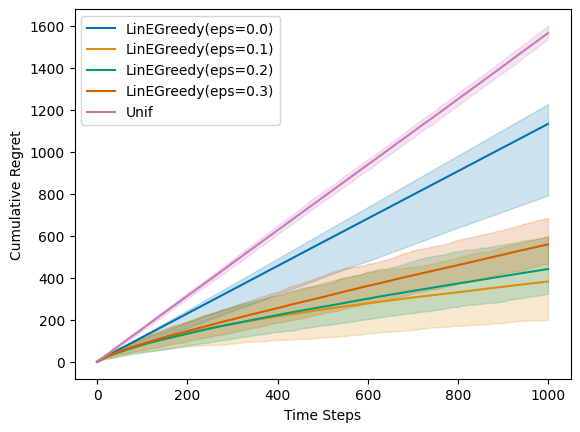

In [114]:
np.random.seed(42)

d = 20
K = 50

features = np.random.rand(K, d)
theta = np.random.rand(d)

linearBanditEnv = LinearBandit(theta, K)

eps_greedy_linear_00 = LinEpsilonGreedy(d, epsilon=0.0)
eps_greedy_linear_10 = LinEpsilonGreedy(d, epsilon=0.1)
eps_greedy_linear_20 = LinEpsilonGreedy(d, epsilon=0.2)
eps_greedy_linear_30 = LinEpsilonGreedy(d, epsilon=0.3)
uniform_linear = LinUniform()

N = 100
T = 1000
regrets = experiment(linearBanditEnv, [eps_greedy_linear_00, eps_greedy_linear_10, eps_greedy_linear_20, eps_greedy_linear_30, uniform_linear], N, T)

plot_regret(regrets)

### Adaptation of LinEpsilonGreedy class using Sherman–Morrison formula to invert A

In [115]:
class LinEpsilonGreedySM:

    def __init__(self, d, lambda_reg=1., epsilon=0.1):
        self.epsilon = epsilon
        self.d = d
        self.lambda_reg = lambda_reg
        self.reset()
    
    def reset(self):
        self.t = 0
        self.A = self.lambda_reg * np.eye(self.d)
        self.invA = 1/self.lambda_reg * np.identity(self.d)
        self.b = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)

    def get_action(self, arms):
        K, _ = arms.shape

        if np.random.rand() < self.epsilon:
            chosen_index = np.random.randint(K)
            return arms[chosen_index, :]

        estimated_rewards = np.dot(arms, self.theta_hat)
        chosen_index = np.argmax(estimated_rewards)
        return arms[chosen_index, :]

    def receive_reward(self, chosen_arm, reward):
        self.t += 1

        x = chosen_arm.reshape(-1, 1)
        invAx = np.dot(self.invA, x)
        denominator = 1 + np.dot(x.T, invAx)
        self.invA -= np.dot(invAx, invAx.T) / denominator

        self.b += reward * chosen_arm
        self.theta_hat = np.inner(self.invA, self.b)

    def name(self):
        return f'LinEGreedySM(eps={self.epsilon})'

### Run LinEpsilonGreedySM for different values of $epsilon$

Running LinEGreedySM(eps=0.0)


100%|██████████| 100/100 [00:00<00:00, 127.58it/s]


Running LinEGreedySM(eps=0.1)


100%|██████████| 100/100 [00:00<00:00, 128.34it/s]


Running LinEGreedySM(eps=0.2)


100%|██████████| 100/100 [00:00<00:00, 128.02it/s]


Running LinEGreedySM(eps=0.3)


100%|██████████| 100/100 [00:00<00:00, 127.88it/s]


Running Unif


100%|██████████| 100/100 [00:00<00:00, 166.11it/s]
/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_16244/2613545160.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


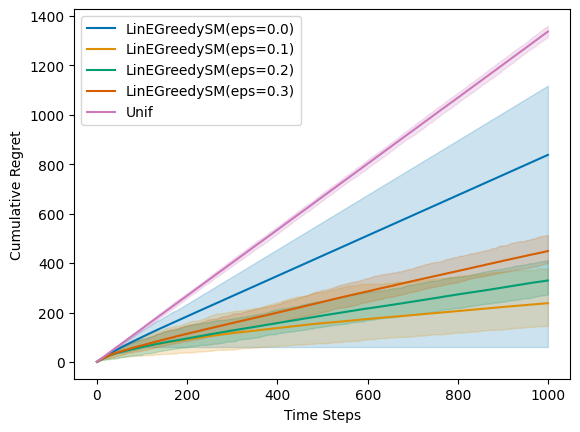

In [116]:
np.random.seed(42)

d = 10
K = 30

features = np.random.rand(K, d)
theta = np.random.rand(d)

linearBanditEnv = LinearBandit(theta, K)

eps_greedy_linear_00 = LinEpsilonGreedySM(d, epsilon=0.0)
eps_greedy_linear_10 = LinEpsilonGreedySM(d, epsilon=0.1)
eps_greedy_linear_20 = LinEpsilonGreedySM(d, epsilon=0.2)
eps_greedy_linear_30 = LinEpsilonGreedySM(d, epsilon=0.3)
uniform_linear = LinUniform()

N = 100
T = 1000
regrets = experiment(linearBanditEnv, [eps_greedy_linear_00, eps_greedy_linear_10, eps_greedy_linear_20, eps_greedy_linear_30, uniform_linear], N, T)

plot_regret(regrets)

### Run LinEpsilonGreedy and LinEpsilonGreedySM for different $d$ values to compare time complexity

100%|██████████| 10/10 [00:00<00:00, 80.45it/s]


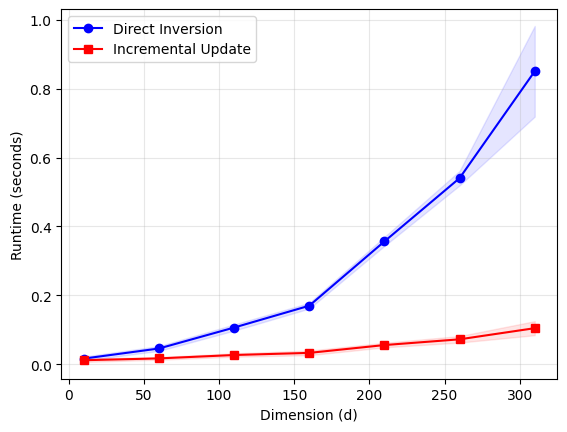

In [117]:
def measure_runtime(linearBanditEnv, agent_class, d, epsilon, N, T):
    agent = agent_class(d=d, epsilon=epsilon)
    start_time = time.time()
    play(linearBanditEnv, agent, N, T)
    end_time = time.time()
    return end_time - start_time

K = 50
num_runs = 100
d_range = range(10, 311, 50)
N = 10
T = 100
epsilon = 0.1

runtime_direct = []
runtime_incremental = []
std_direct = []
std_incremental = []

np.random.seed(42)

for d in d_range:
    theta = np.random.rand(d)
    linearBanditEnv = LinearBandit(theta, K)

    runtimes_direct_d = []
    runtimes_incremental_d = []
    
    for _ in range(num_runs):
        runtimes_direct_d.append(measure_runtime(linearBanditEnv, LinEpsilonGreedy, d, epsilon, N, T))
        runtimes_incremental_d.append(measure_runtime(linearBanditEnv, LinEpsilonGreedySM, d, epsilon, N, T))
    
    avg_runtime_direct = np.mean(runtimes_direct_d)
    std_runtime_direct = np.std(runtimes_direct_d)
    
    avg_runtime_incremental = np.mean(runtimes_incremental_d)
    std_runtime_incremental = np.std(runtimes_incremental_d)
    
    runtime_direct.append(avg_runtime_direct)
    runtime_incremental.append(avg_runtime_incremental)
    std_direct.append(std_runtime_direct)
    std_incremental.append(std_runtime_incremental)

plt.plot(d_range, runtime_direct, label='Direct Inversion', color='blue', marker='o')
plt.fill_between(d_range, 
                 np.array(runtime_direct) - np.array(std_direct), 
                 np.array(runtime_direct) + np.array(std_direct), 
                 color='blue', alpha=0.1)
plt.plot(d_range, runtime_incremental, label='Incremental Update', color='red', marker='s')
plt.fill_between(d_range, 
                 np.array(runtime_incremental) - np.array(std_incremental), 
                 np.array(runtime_incremental) + np.array(std_incremental), 
                 color='red', alpha=0.1)
plt.xlabel('Dimension (d)')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Question 2

### LinUCB policy

In [8]:
class LinUCB:

    def __init__(self, d, delta=1., sigma=1., lambda_reg=1.):
        self.d = d
        self.delta = delta
        self.sigma = sigma
        self.lambda_reg = lambda_reg
        self.reset()
    
    def reset(self):
        self.t = 0
        self.A = self.lambda_reg * np.eye(self.d)
        self.invA = 1/self.lambda_reg * np.identity(self.d)
        self.b = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)

    def get_action(self, arms):
        K, _ = arms.shape
        ucb_values = np.zeros(K)

        for i, x in enumerate(arms):
            x = x.reshape(-1, 1)
            mean_estimate = np.dot(self.theta_hat, x)
            uncertainty = self.sigma * np.sqrt(np.dot(x.T, np.dot(self.invA, x)))
            ucb_values[i] = mean_estimate + self.delta * uncertainty

        best_index = np.argmax(ucb_values)
        return arms[best_index, :]

    def receive_reward(self, chosen_arm, reward):
        self.t += 1
        self.A += np.outer(chosen_arm, chosen_arm)
        self.invA = np.linalg.inv(self.A)
        self.b += reward * chosen_arm
        self.theta_hat = np.inner(self.invA, self.b)

    def name(self):
        return f'LinUCB(delta={self.delta})'

### LinTS policy

In [9]:
class LinTS:

    def __init__(self, d, sigma=1., lambda_reg=1.):
        self.d = d
        self.sigma = sigma
        self.lambda_reg = lambda_reg
        self.reset()
    
    def reset(self):
        self.t = 0
        self.A = self.lambda_reg * np.eye(self.d)
        self.invA = 1/self.lambda_reg * np.identity(self.d)
        self.b = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)

    def get_action(self, arms):
        L = np.linalg.cholesky(self.sigma**2 * self.invA)
        z = np.random.randn(self.d)
        theta_sample = self.theta_hat + np.dot(L, z)
        rewards = np.dot(arms, theta_sample)
        best_index = np.argmax(rewards)
        return arms[best_index, :]

    def receive_reward(self, chosen_arm, reward):
        self.t += 1
        self.A += np.outer(chosen_arm, chosen_arm)
        self.invA = np.linalg.inv(self.A)
        self.b += reward * chosen_arm
        self.theta_hat = np.inner(self.invA, self.b)

    def name(self):
        return f'LinTS(sigma={self.sigma})'

### Run LinUCB and LinTS

Running LinEGreedy(eps=0.1)


100%|██████████| 100/100 [00:01<00:00, 69.09it/s]


Running LinUCB(delta=1.0)


  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/4253231842.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_estimate + self.delta * uncertainty
100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


Running LinUCB(delta=0.1)


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Running LinTS(sigma=1.0)


100%|██████████| 100/100 [00:02<00:00, 45.38it/s]


Running LinTS(sigma=0.1)


100%|██████████| 100/100 [00:02<00:00, 45.25it/s]
/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/2613545160.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


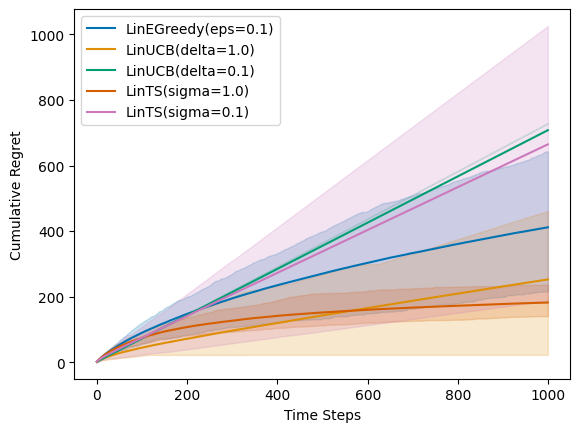

In [12]:
np.random.seed(42)

d = 20
K = 50

features = np.random.rand(K, d)
theta = np.random.rand(d)

linearBanditEnv = LinearBandit(theta, K)

eps_greedy = LinEpsilonGreedy(d)
lin_ucb_10 = LinUCB(d)
lin_ucb_01 = LinUCB(d, delta=0.1)
lin_ts_10 = LinTS(d)
lin_ts_01 = LinTS(d, sigma=0.1)

N = 100
T = 1000
regrets = experiment(linearBanditEnv, [eps_greedy, lin_ucb_10, lin_ucb_01, lin_ts_10, lin_ts_01], N, T)

plot_regret(regrets)

Running for K=10, d=5


/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/4253231842.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_estimate + self.delta * uncertainty


Running for K=10, d=10
Running for K=10, d=20
Running for K=10, d=50
Running for K=10, d=100
Running for K=50, d=5
Running for K=50, d=10
Running for K=50, d=20
Running for K=50, d=50
Running for K=50, d=100
Running for K=100, d=5
Running for K=100, d=10
Running for K=100, d=20
Running for K=100, d=50
Running for K=100, d=100
Running for K=200, d=5
Running for K=200, d=10
Running for K=200, d=20
Running for K=200, d=50
Running for K=200, d=100
Running for K=500, d=5
Running for K=500, d=10
Running for K=500, d=20
Running for K=500, d=50
Running for K=500, d=100
Algorithm 0: LinUCB(delta=1.0)
Algorithm 1: LinUCB(delta=0.1)
Algorithm 2: LinTS(sigma=1.0)
Algorithm 3: LinTS(sigma=0.1)
Algorithm 4: LinEGreedy(eps=0.1)


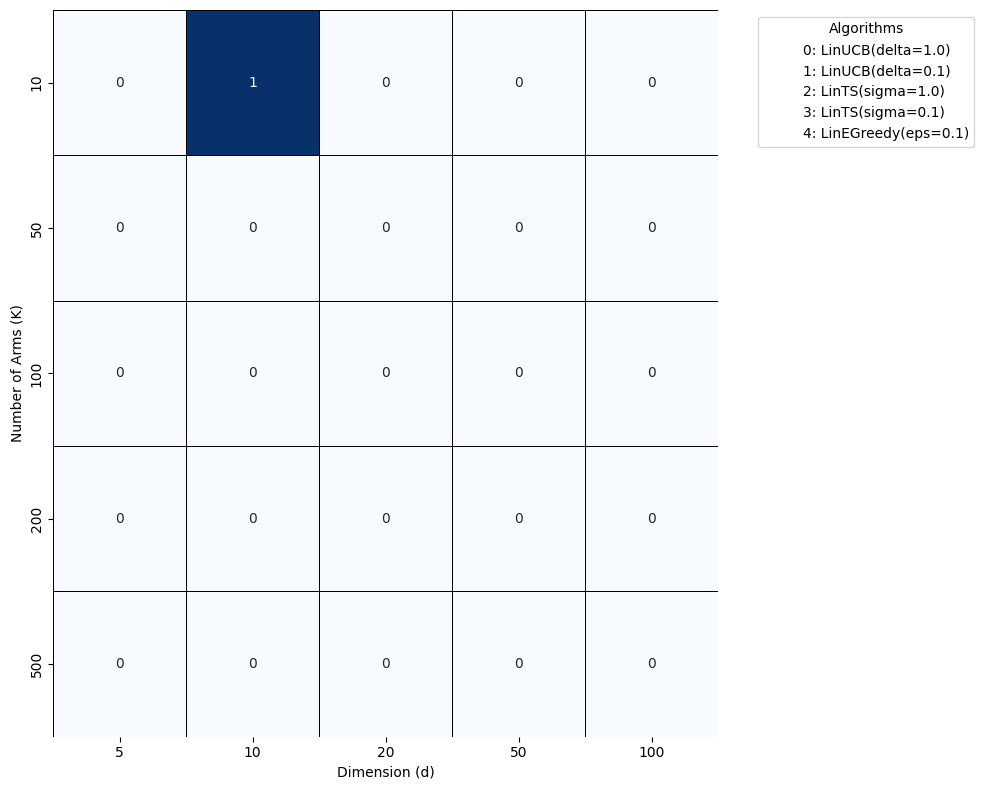

In [ ]:
def get_algorithms(d):
    return [LinUCB(d=d, delta=1.), LinUCB(d=d, delta=0.1), LinTS(d=d, sigma=1.0), LinTS(d=d, sigma=0.1), LinEpsilonGreedy(d=d, epsilon=0.1)]

def experiment(environment, agents, Nmc, T):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """
    all_data = {}
    for agent in agents:
        cumulative_regrets = []
        for _ in range(Nmc):
            agent.reset()
            cumulative_regret = 0
            for t in range(T):
                arms = environment.get_action_set()
                chosen_arm = agent.get_action(arms)
                reward = environment.get_reward(chosen_arm)
                agent.receive_reward(chosen_arm, reward)
                optimal_reward = np.max(environment.get_means())
                cumulative_regret += (optimal_reward - reward)
            cumulative_regrets.append(cumulative_regret)
        all_data[agent.name()] = np.mean(cumulative_regrets)
    return all_data

def evaluate_algorithms(K_values, d_values, T, seeds):
    """
    Evaluate algorithms for all (K, d) pairs and return a heatmap matrix.
    """
    heatmap_data = np.zeros((len(K_values), len(d_values)), dtype=int)
    algorithms_names = [
        "LinUCB(delta=1.0)",
        "LinUCB(delta=0.1)",
        "LinTS(sigma=1.0)",
        "LinTS(sigma=0.1)",
        "LinEGreedy(eps=0.1)",
    ]
    
    for i, K in enumerate(K_values):
        for j, d in enumerate(d_values):
            print(f"Running for K={K}, d={d}")
            wins = np.zeros(len(algorithms_names))
            
            for seed in seeds:
                np.random.seed(seed)
                theta = np.random.rand(d)
                env = LinearBandit(theta, K)

                agents = get_algorithms(d)
                regrets = experiment(env, agents, Nmc=1, T=T)
                
                best_alg_name = min(regrets, key=regrets.get)
                best_alg_index = algorithms_names.index(best_alg_name)
                wins[best_alg_index] += 1

            heatmap_data[i, j] = np.argmax(wins)
    
    return heatmap_data, algorithms_names

K_values = [10, 50, 100, 200, 500]
d_values = [5, 10, 20, 50, 100]
T = 500
seeds = range(100)

heatmap_data, algorithms = evaluate_algorithms(K_values, d_values, T, seeds)

sns.heatmap(
    heatmap_data,
    xticklabels=d_values,
    yticklabels=K_values,
    annot=heatmap_data,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="black"
)
plt.xlabel("Dimension (d)")
plt.ylabel("Number of Arms (K)")

for i, alg in enumerate(algorithms):
    print(f"Algorithm {i}: {alg}")

legend_patches = [Patch(color="white", label=f"{i}: {alg}") for i, alg in enumerate(algorithms)]
plt.legend(
    handles=legend_patches, title="Algorithms", bbox_to_anchor=(1.05, 1), loc="upper left"
)

plt.tight_layout()
plt.show()

# Bonus Question

In [22]:
def play_fixed(environment, agent, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    actions: a fixed action set. Default is set to be the canonical basis.
    """

    data = np.zeros((Nmc, T))

    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            # action_set = environment.get_action_set() -> We no longer call on your ActionsGenerator function
            action_set = np.copy(actions) # the actions given as input
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data

In [23]:
def experiment_fixed(environment, agents, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}
    if actions is None:
      actions = ActionsGenerator(K,d) #call it once!
    print(f'fixed action set = {actions}')

    n = len(agents)
    for i, agent in tqdm(enumerate(agents)):
        print(f'running agent {i+1} ({agent.name()}) / {n}')
        agent_id, regrets = play_fixed(environment, agent, Nmc, T, actions, pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

In [24]:
class UCB:
  def __init__(self, K, var):
      self.K = K
      self.var = var
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def get_action(self,action_set):
      if self.t < self.K:
        action = self.t
      else:
        empirical_means = self.count_rewards / self.count_actions
        ucbs = np.sqrt(6 * self.var * np.log(self.t) / self.count_actions) # 6 could be replaced by a 2, try it out :)
        action = np.argmax(empirical_means + ucbs)

      self.t += 1
      self.count_actions[action] += 1
      self.current_action = action #need to remember the *index* of the action now
      return action_set[action,:]

  def receive_reward(self, action, reward):
      self.count_rewards[self.current_action] += reward

  def reset(self):
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def name(self):
      return 'UCB('+str(self.var)+')'

In [ ]:
d=3
K=7 # same as before, more actions than dimension

theta = ActionsGenerator(1,d).reshape(-1) # draw a new, random, environment's theta to learn
theta /= np.linalg.norm(theta)

# fixed action set
fixed_actions = ActionsGenerator(K,d) #call it once!
print(f'fixed actions set = {fixed_actions}')

env = LinearBandit(theta, K, fixed_actions=fixed_actions)
ucb = UCB(K, var=1.)
linucb = LinUCB(d, delta=0.01, sigma=1., lambda_reg=1.)
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=fixed_actions, pseudo_regret=True)

fixed actions set = [[-0.96479369  0.04603132 -0.25894835]
 [-0.06541897  0.38443555 -0.92083096]
 [ 0.1834577  -0.95070077  0.25002262]
 [-0.89147361 -0.2679223  -0.36536618]
 [-0.00460104  0.94134659  0.33740988]
 [ 0.93908855 -0.06846617  0.33678641]
 [ 0.51229518 -0.44131287  0.7367473 ]]
fixed action set = [[-0.96479369  0.04603132 -0.25894835]
 [-0.06541897  0.38443555 -0.92083096]
 [ 0.1834577  -0.95070077  0.25002262]
 [-0.89147361 -0.2679223  -0.36536618]
 [-0.00460104  0.94134659  0.33740988]
 [ 0.93908855 -0.06846617  0.33678641]
 [ 0.51229518 -0.44131287  0.7367473 ]]


0it [00:00, ?it/s]/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/4253231842.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_estimate + self.delta * uncertainty
2it [00:00, 16.52it/s]

running agent 1 (UCB(1.0)) / 2
running agent 2 (LinUCB(delta=0.01)) / 2


/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/2613545160.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


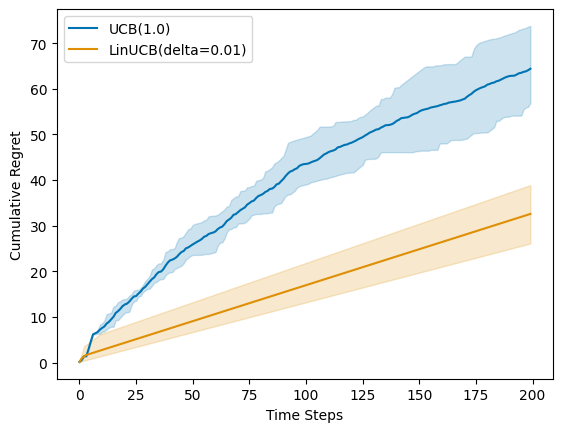

In [55]:
plot_regret(reg_fixed_actions)

In [ ]:
d=7
K=d
# theta = np.random.multivariate_normal(np.zeros(d),np.eye(d))
theta = np.linspace(0.1,1,num=d) # just d actions in increasing value order
#theta = your choice of parameter
theta /= np.linalg.norm(theta) #optional if you set theta with bounded norm :)

env = LinearBandit(theta, d, fixed_actions=np.eye(d))
ucb = UCB(d, var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=np.eye(d), pseudo_regret=True)

fixed action set = [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


0it [00:00, ?it/s]/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/4253231842.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_estimate + self.delta * uncertainty
2it [00:00, 19.05it/s]

running agent 1 (UCB(1.0)) / 2
running agent 2 (LinUCB(delta=0.01)) / 2


/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/2613545160.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


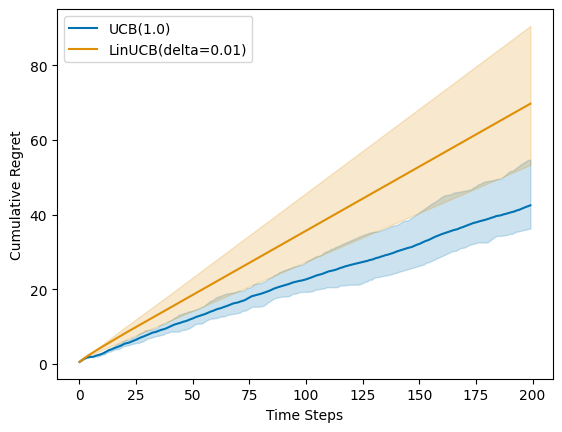

In [53]:
plot_regret(reg_fixed_actions)

In [ ]:
np.random.seed(23)

d = 2
K = 3
epsilon = 0.1
alpha = 1

fixed_actions = np.array([[1, 0], [0, 1], [1-epsilon, 8*epsilon*alpha]])
theta = np.array([1, 0])

env = LinearBandit(theta=theta, K=K, fixed_actions=fixed_actions)
ucb = UCB(d, var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1.)
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=fixed_actions, pseudo_regret=True)

fixed action set = [[1.   0.  ]
 [0.   1.  ]
 [0.99 0.08]]


0it [00:00, ?it/s]/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/4253231842.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_estimate + self.delta * uncertainty
2it [00:00, 18.33it/s]

running agent 1 (UCB(1.0)) / 2
running agent 2 (LinUCB(delta=0.01)) / 2


/var/folders/xh/bm_l2jz916s7t2p3pwrcr9y80000gn/T/ipykernel_18341/2613545160.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


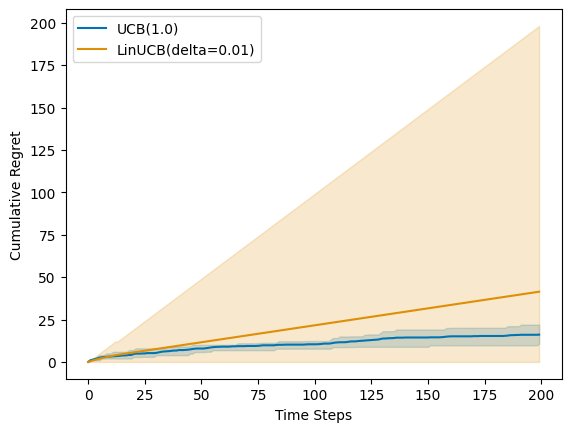

In [114]:
plot_regret(reg_fixed_actions)